In [5]:
import os

print("Current Working Directory:", os.getcwd())
import pt_inference


Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\pt_inference


Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
part_mask shape (512, 512)
binary_skin_mask_stacked shape (512, 512, 3)
image shape (512, 512, 3)
part_mask shape (512, 512)
binary_skin_mask_stacked shape (512, 512, 3)
image shape (512, 512, 3)
skin shape (512, 512, 3)


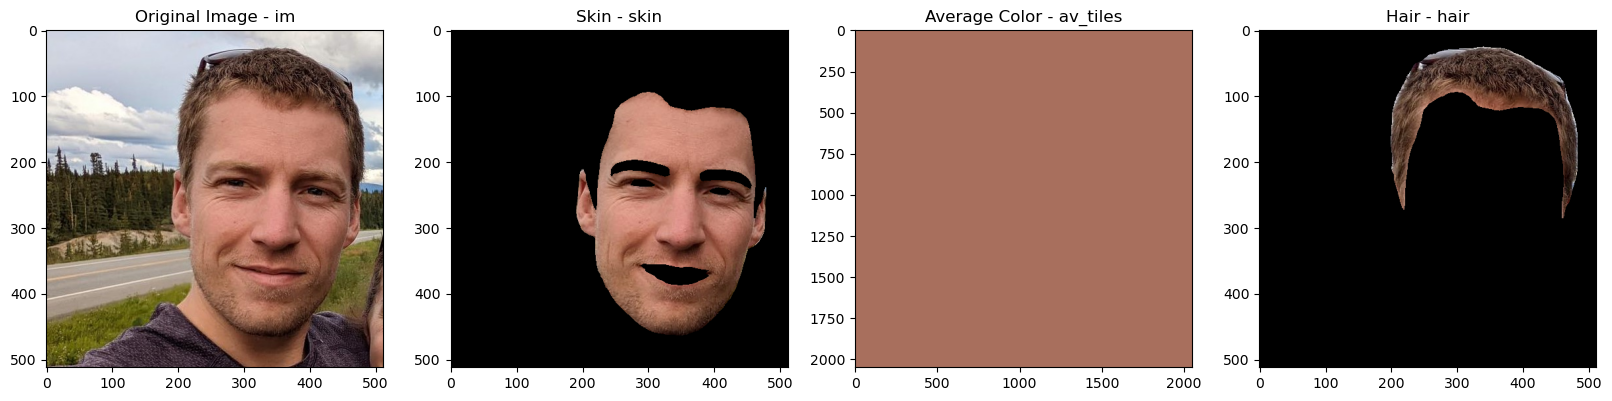

In [2]:
import sys

import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
importlib.reload(torch_face)
im_path = r"C:\Desktop\joel.jpg"
im = Image.open(im_path)
im = im.convert('RGB')
im = np.array(im)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
combined = ['l_ear', 'r_ear','skin', 'mouth', 'nose']
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
part_mask = segmenter.process_image(im, combined)
skin, mask = segmenter.get_skin(im)
av_skin_tile = segmenter.get_skin_tile(im)
hair = segmenter.get_hair(im)
ax[0].imshow(im)
ax[0].set_title('Original Image - im')
ax[1].imshow(part_mask)
ax[1].set_title('Part Mask - part_mask')
ax[1].imshow(skin)
ax[1].set_title('Skin - skin')
ax[2].imshow(av_skin_tile.astype(np.uint8))
ax[2].set_title('Average Color - av_tiles')
ax[3].imshow(part_mask)
ax[3].set_title('Part Mask - part_mask')
ax[3].imshow(hair)
ax[3].set_title('Hair - hair')
plt.show()

skin_mask = segmenter.process_image

Encoder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=5, bias=True)
  )
)
Decoder(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=3, bias=True)
  )
)
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
['C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053411.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053412.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053415.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipelin

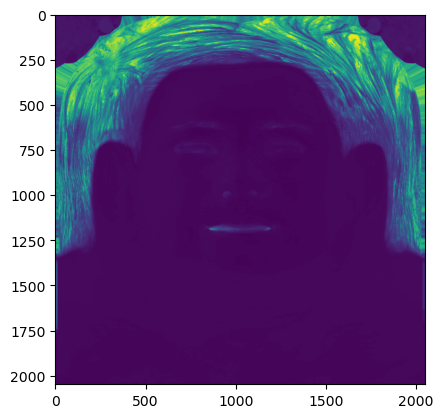

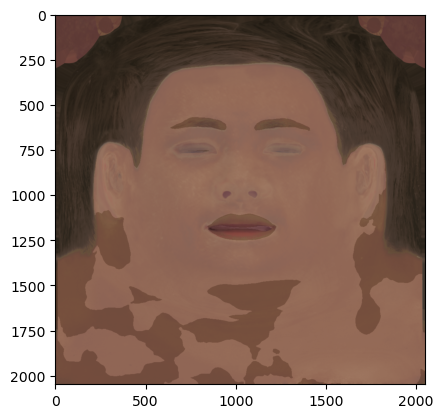

part_mask shape (1024, 1024)
binary_skin_mask_stacked shape (1024, 1024, 3)
image shape (1024, 1024, 3)
(2048, 2048, 3)
encoded_features shape: (4194304, 5)


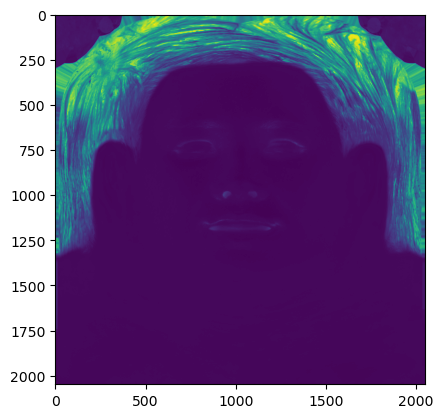

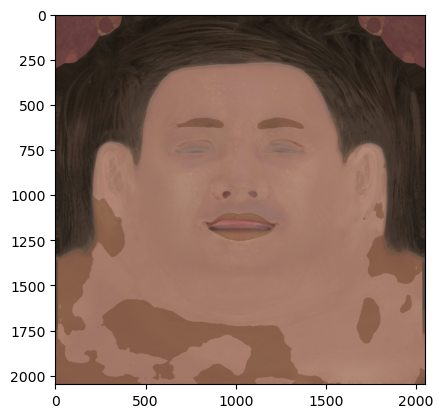

In [6]:

import sys
import cv2
import importlib
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append('fitzpatrick')
def apply_changes_to_skin_channel(chromophore_map, channel_index, skin_mask=None):
    if skin_mask is None:
        skin_mask = np.ones_like(chromophore_map).astype(bool)
    # Ensure the mask is boolean and the same shape as the chromophore map's spatial dimensions
    skin_mask = skin_mask.astype(bool)
    
    # Extract the specified channel from the chromophore map
    channel_to_modify = chromophore_map[:, :, channel_index]

    # Apply changes only to the skin regions of the specified channel
    modified_channel = channel_to_modify.copy()
    modified_channel[skin_mask] = (channel_to_modify[skin_mask] * 0.5) + 0.0

    # Place the modified channel back into the chromophore map
    modified_map = chromophore_map.copy()
    modified_map[:, :, channel_index] = modified_channel

    return modified_map
def reverse_gamma_correction(img):
    """Reverse gamma correction on an image."""
    #if image > 1
    if np.max(img) > 1:
        img = img / 255.0
    return np.where(img > 0.04045, ((img + 0.055) / 1.055) ** 2.4, img / 12.92)
    # return np.array(img)

def gamma_correction(img):
    if np.max(img) > 1:
        img = img / 255.0
    """Gamma correction on an image."""
    return np.where(img > 0.0031308, 1.055 * (img ** (1 / 2.4)) - 0.055, 12.92 * img)

import pt_inference
import pt_inference.pt_ae as ae
importlib.reload(ae)
my_autoencoder = ae.MyAutoencoder(device='cuda')
encoder = my_autoencoder.get_encoder()
decoder = my_autoencoder.get_decoder()
print(encoder)
print(decoder)
image_dir = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick"
image_paths  =  os.listdir(image_dir)
image_paths = [os.path.join(image_dir, im) for im in image_paths]
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
print(image_paths)
for im_path in image_paths[:2]:
    im = Image.open(im_path)
    im = im.convert('RGB')
    im = np.array(im)
    if im is None:
        print('Image not found')
        continue
    combined = ['l_ear', 'r_ear','skin', 'mouth', 'nose']
    skin, skin_mask = segmenter.get_skin(im)

    im = cv2.resize(im, (2048, 2048))
    im = im.astype(np.float32)
    print(im.shape)
    encoded_features = my_autoencoder.encode_image(im)
    pm = encoded_features.reshape(2048, 2048, 5)
    cm = pm[:,:,0]

    skin_mask = cv2.resize(skin_mask.astype(np.float32), (2048, 2048))

    pm  = apply_changes_to_skin_channel(pm, channel_index=0, skin_mask=skin_mask)

    plt.imshow(cm)
    plt.show()
    decoded_image = my_autoencoder.decode_image(pm, width=im.shape[1], height=im.shape[0])
    # print(decoded_image)
    plt.imshow(decoded_image)
    plt.show()